In [ ]:
# !pip install geemap

# AWD monitoring using Sentinel 1

In [2]:
import ee
import geemap
import datetime
import random

import pandas as pd
import numpy as np
import plotly.express as px
from tqdm import tqdm

In [3]:
ee.Initialize()

### 1. Create 200 location coordinates

In [4]:
number_of_loc = 10

min_lat = 23.0
max_lat = 24.0
min_lon = 88.0
max_lon = 89.0

locations = []
for i in range(number_of_loc):
    lat = random.uniform(min_lat, max_lat)
    lon = random.uniform(min_lon, max_lon)
    locations.append((lat, lon))
    
# Convert the list of locations to Earth Engine points
points = [ee.Geometry.Point(lon, lat) for lat, lon in locations]

### 2. Sentinel-1 VV, NDVI, Precipitation

In [5]:
# Define the start and end dates
start_date = '2022-01-01'
end_date = '2022-07-31'

# Filter the Sentinel-1 VV dataset to the date range
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

# Filter the Sentinel-2 dataset to the date range and calculate NDVI
sentinel_2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate(start_date, end_date) \
    .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI'))


# Filter the CHIRPS precipitation dataset to the date range
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
    .filterDate(start_date, end_date) \
    .select('precipitation')

In [6]:
# Initialize an empty list to store DataFrames for each point
dfs = []

# Loop through all points and extract Sentinel-1 VV data, NDVI, and precipitation
for i, point in enumerate(points):
    # Extract Sentinel-1 VV values
    vv_values = sentinel_1.getRegion(point, 10).getInfo()
    
    # Extract NDVI values
    ndvi_values = sentinel_2.getRegion(point, 10).getInfo()
    
    # Extract precipitation values
    precipitation_values = precipitation.getRegion(point, 10).getInfo()
    
    # Convert the time series to a Pandas DataFrame for the current point
    df_vv = pd.DataFrame(vv_values[1:], columns=vv_values[0])
    df_ndvi = pd.DataFrame(ndvi_values[1:], columns=ndvi_values[0])
    df_precipitation = pd.DataFrame(precipitation_values[1:], columns=precipitation_values[0])
    
    # Filter out rows with None values in the 'time' column
    df_vv = df_vv[df_vv['time'].notna()]
    df_ndvi = df_ndvi[df_ndvi['time'].notna()]
    df_precipitation = df_precipitation[df_precipitation['time'].notna()]
    
    # Convert 'time' columns to int64 data type
    df_vv['time'] = df_vv['time'].astype('int64')
    df_ndvi['time'] = df_ndvi['time'].astype('int64')
    df_precipitation['time'] = df_precipitation['time'].astype('int64')
    
    # Merge DataFrames based on 'time' column
    df_merged = pd.merge(df_vv, df_ndvi, on='time', how='outer', suffixes=('_vv', '_ndvi'))
    df_merged = pd.merge(df_merged, df_precipitation, on='time', how='outer')
    
    # Convert time column to datetime and create 'date' column
    df_merged['time'] = pd.to_datetime(df_merged['time'], unit='ms')
    df_merged['date'] = df_merged['time'].dt.date
    
    # Convert data columns to float
    df_merged['VV'] = df_merged['VV'].astype(float)
    df_merged['NDVI'] = df_merged['NDVI'].astype(float)
    df_merged['precipitation'] = df_merged['precipitation'].astype(float)
    
    # Add the point index as a new column
    df_merged['point_index'] = i
    
    # Append the current point's DataFrame to the list
    dfs.append(df_merged)

# Concatenate all DataFrames in the list to create the overall DataFrame
all_df = pd.concat(dfs)

# Calculate the mean VV, NDVI, and precipitation value for each date and point_index
df_mean = all_df.groupby(['date', 'point_index']).mean().reset_index()

# Optionally, you can pivot the DataFrame to have one column per point_index for each variable
df_mean_pivot = df_mean.pivot_table(index='date', columns='point_index', values=['VV', 'NDVI', 'precipitation'])


In [7]:
df_mean_b = df_mean[['date','VV','precipitation']]
# Set 'date' as the index of the DataFrame (if it's not already the index)
df_mean_b = df_mean_b.set_index('date')
df_mean_b.head(2)

,VV,precipitation
date,,
2022-01-01,NaN,1.719740
2022-01-01,NaN,1.565801


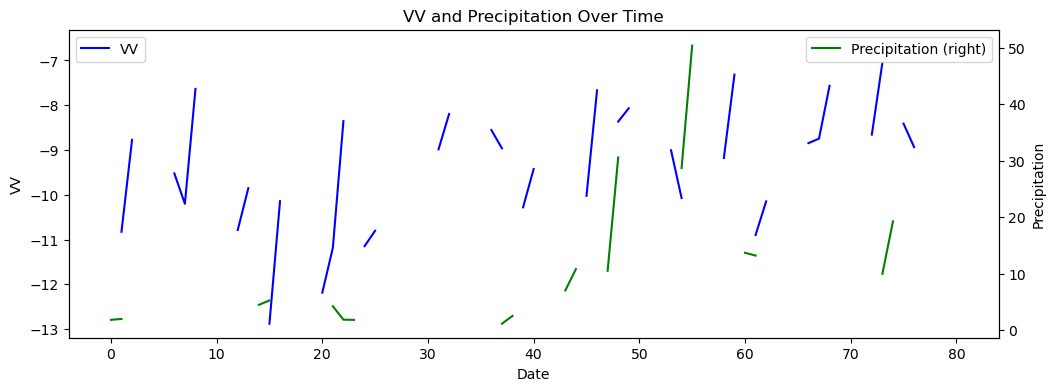

In [8]:
import matplotlib.pyplot as plt

# Group the DataFrame by the 'date' column and calculate the mean for each unique date
df_mean_grouped = df_mean_b.groupby('date').mean().reset_index()

# Create line plot for 'VV' column
ax = df_mean_grouped['VV'].plot(color='blue', label='VV', figsize=(12, 4))

# Create line plot for 'precipitation' column with secondary y-axis
ax2 = df_mean_grouped['precipitation'].plot(color='green', label='Precipitation', secondary_y=True, ax=ax)

# Add labels for axes
ax.set_xlabel('Date')
ax.set_ylabel('VV')
ax2.set_ylabel('Precipitation')

# Add title
ax.set_title('VV and Precipitation Over Time')

# Add legend
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


### 3. Create water depth

In [9]:
# Generate a list of dates between the start and end dates
date_range = pd.date_range(start_date, end_date)

# Number of locations
number_of_loc = len(points)

# Define the minimum and maximum water depth
min_depth = 0
max_depth = 10

# Initialize an empty dictionary to store water depth data
water_depth_data = {'date': date_range}

# Generate random water depths for each location and date
for i in range(number_of_loc):
    water_depth_data[f'location_{i}'] = np.random.uniform(min_depth, max_depth, len(date_range))

# Create a DataFrame with water depth data
df_water_depth = pd.DataFrame(water_depth_data)

df_mean_pivot['date'] = df_mean_pivot.index


In [10]:
# Melt the df_water_depth DataFrame to unpivot the location columns
df_water_depth_long = pd.melt(df_water_depth, id_vars=['date'], value_vars=[f'location_{i}' for i in range(number_of_loc)], var_name='point_index', value_name='water_depth')

# Extract the index number from the 'point_index' column (e.g., from 'location_0' to 0)
df_water_depth_long['point_index'] = df_water_depth_long['point_index'].str.extract('(\d+)').astype(int)

# The resulting DataFrame has columns 'date', 'water_depth', and 'point_index'


In [11]:
type(df_water_depth_long.date)

pandas.core.series.Series

In [12]:
# Convert the 'date' column in both DataFrames to datetime64[ns] data type
df_mean['date'] = pd.to_datetime(df_mean['date'])
df_water_depth_long['date'] = pd.to_datetime(df_water_depth_long['date'])

# Merge df_mean and df_water_depth_long based on 'date' and 'point_index'
df_merged = pd.merge(df_mean, df_water_depth_long, on=['date', 'point_index'], how='inner')

df_merged = df_merged[['date', 'point_index', 'VV', 'precipitation','water_depth']]

In [13]:
# Drop all rows containing missing values (NaN) from df_merged
df_merged_clean = df_merged.dropna()

In [14]:
coefficient = 0.5
noise_amplitude = 1

# Generate random noise
random_noise = np.random.uniform(-noise_amplitude, noise_amplitude, len(df_merged_clean))

# Create the water_depth_v2 column by multiplying the VV column by the coefficient and adding random noise
df_merged_clean['water_depth_v2'] = -(df_merged_clean['VV'] * coefficient + random_noise)

df_merged_clean.head(2)

/var/folders/24/0hnc07_91nndxxzhr7g6vpvm0000gq/T/ipykernel_9137/280033674.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_clean['water_depth_v2'] = -(df_merged_clean['VV'] * coefficient + random_noise)


,date,point_index,VV,precipitation,water_depth,water_depth_v2
11,2022-01-06,1,-9.513738,1.631968,5.618749,4.439951
14,2022-01-06,4,-13.724650,1.552783,3.332443,6.678936


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [16]:
import matplotlib.pyplot as plt

Mean Squared Error (MSE): 0.29021339412350333
R-squared (R2): 0.826582607587504


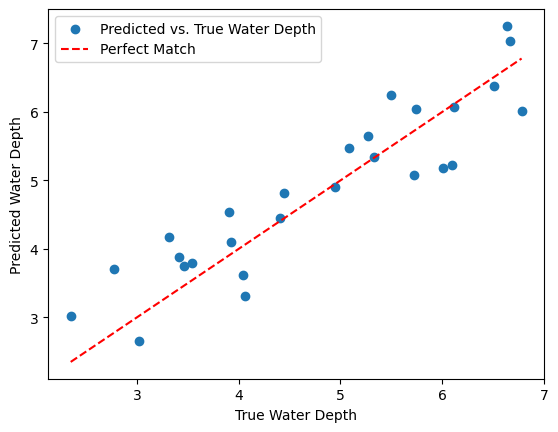

In [17]:
# Select features (VV) and label (water_depth)
features = df_merged_clean[['VV']]
label = df_merged_clean['water_depth_v2']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Create a scatter plot of true vs. predicted water depth values
plt.scatter(y_test, y_pred, label='Predicted vs. True Water Depth')
plt.xlabel('True Water Depth')
plt.ylabel('Predicted Water Depth')

# Plot a diagonal line representing a perfect match
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Match')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [18]:
df_merged_clean

,date,point_index,VV,precipitation,water_depth,water_depth_v2
11,2022-01-06,1,-9.513738,1.631968,5.618749,4.439951
14,2022-01-06,4,-13.724650,1.552783,3.332443,6.678936
17,2022-01-06,7,-8.411102,1.580183,5.503864,3.256936
18,2022-01-06,8,-11.892384,1.758492,5.645665,6.806593
19,2022-01-06,9,-10.590664,1.928917,9.155935,5.331048
...,...,...,...,...,...,...
680,2022-07-11,5,-8.791650,19.858765,6.338641,5.256619
681,2022-07-11,6,-6.993031,8.050732,4.192800,4.039933
682,2022-07-11,7,-7.016476,4.631089,8.009668,2.544150
683,2022-07-11,8,-8.937905,5.280825,8.060858,5.428400


In [19]:
from scipy.interpolate import griddata
geometry = ee.Geometry.Polygon([
    [88.45, 23.65],
    [88.46, 23.65],
    [88.46, 23.66],
    [88.45, 23.66]
])

In [20]:
m = geemap.Map()

imgVV = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV') \
    .map(lambda image: image.updateMask(image.lt(-30.0).Not().mask()))

desc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
asc = imgVV.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))

def generate_monthly_filter_dates(start_date, end_date):
    # Generate monthly date ranges
    date_range = pd.date_range(start_date, end_date, freq='M')
    
    # Generate filter dates as pairs of (start date, end date) for each month
    filter_dates = []
    for i, date in enumerate(date_range):
        if i == 0:
            start = pd.Timestamp(start_date)
        else:
            start = date_range[i-1] + pd.Timedelta(days=1)
        end = date
        filter_dates.append((start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')))
    
    # Add the remaining days in the last month
    last_month_end = pd.Timestamp(end_date)
    if date_range[-1] < last_month_end:
        filter_dates.append(((date_range[-1] + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), last_month_end.strftime('%Y-%m-%d')))
    
    return filter_dates

# Generate filter dates
filter_dates = generate_monthly_filter_dates(start_date, end_date)

# Compute the mean image for each filter date (example usage)
mean_images = [imgVV.filterDate(start_date, end_date).mean() for start_date, end_date in filter_dates]

# Get the middle date of each filter date range
middle_dates = [(datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=14)).strftime('%Y-%m-%d') for start_date, end_date in filter_dates]

# Add each mean image as a layer to the map, with the middle date as the layer label
for mean_image, middle_date in zip(mean_images, middle_dates):
    m.addLayer(mean_image, {'min': -25, 'max': 5}, middle_date, True)

f = imgVV.filterBounds(geometry).filterDate(start_date, end_date)

# Put all dates in a list
dates = f.aggregate_array("system:time_start").map(lambda d: ee.Date(d))

# Print a list with dates
# print(dates.getInfo())

In [21]:
m.centerObject(geometry, zoom=15)
m.add_basemap('HYBRID')
m.addLayer(geometry, {'color': 'red'}, 'Polygon')

m

Map(center=[23.655000016467923, 88.45500000001641], controls=(WidgetControl(options=['position', 'transparent_…

In [22]:
image = imgVV.filterDate('2023-02-15', '2023-02-16').first()
image = image.multiply(1.6)
m.addLayer(image, {'min': -25, 'max': 5}, '2023-02-15 (x1.6)', True)
m

Map(center=[23.655000016467923, 88.45500000001641], controls=(WidgetControl(options=['position', 'transparent_…

In [23]:
import folium
from branca.colormap import LinearColormap

In [24]:
# Your existing code to create the imgVV ImageCollection and filter by date

# Filter the imgVV ImageCollection by the geometry
imgVV = imgVV.filterBounds(geometry)

# Get the most recent VV image from the filtered ImageCollection
recent_vv_image = imgVV.sort('system:time_start', False).first()

# Function to apply the linear regression model to an image
def apply_regression(image):
    return image.multiply(model.coef_[0]).add(model.intercept_).rename('predicted_water_depth')

# Apply the regression model to the recent VV image
predicted_water_depth_image = apply_regression(recent_vv_image)

# Define visualization parameters for the predicted water depth
predicted_water_depth_vis_params = {
    'min': 0,
    'max': 10,
    'palette': ['blue', 'aqua', 'green', 'yellow', 'orange', 'red']
}

# Create a Map
m = geemap.Map()

# Add the predicted water depth image to the map
m.addLayer(predicted_water_depth_image, predicted_water_depth_vis_params, 'Predicted Water Depth')

# Set the map view to the region of interest
m.add_basemap('HYBRID')
m.centerObject(geometry, zoom=15)
m.addLayer(geometry, {'color': 'red'}, 'Polygon')
# Display the map
m


Map(center=[23.655000016467923, 88.45500000001641], controls=(WidgetControl(options=['position', 'transparent_…